## Implementation of DDPG algorithm
DDPG learns both a Q function as well as a policy function. The Q function is used to learn the policy. DDPG can be seen as the continuous version of DQN, where the action is no longer determined by argmax Q(s,a), but by approximation max Q(s,a) = Q(s, mu(s)), where the mu(s) is estimated by the policy network. DDPG also uses target networks, which are delayed copies of the policy and q networks. 

This implementation uses Gaussian noise which is added to the actions (resulting from deterministic policy), such that exploration is encouraged. Further, initially pure random steps can be stored to prevent overfitting.

The resulting algorithm is tested on Pendulum environent from OpenAI gym. This environment is considered solved when the reward is 0. 

*code is inspired by OpenAI's code

In [1]:
import numpy as np
import scipy.signal
import gym
from torch.optim import Adam
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt

Networks - actor & q and their targets

In [2]:
class MLPActorCritic(nn.Module):


    def __init__(self,obs_dim, act_dim, act_limit,
                 hidden_sizes = (64,64), activation=nn.Tanh):
        super().__init__()
        #build actor and critic & target actor and critic
        self.pi = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit) #actor
        self.q  = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation) #critic
        self.pi_target = MLPActor(obs_dim, act_dim, hidden_sizes, activation, act_limit) # target actor
        self.q_target = MLPQFunction(obs_dim, act_dim, hidden_sizes, activation) # critic target
        
        # make parameters match
        for target_param, param in zip(self.pi_target.parameters(), self.pi.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.q_target.parameters(), self.q.parameters()):
            target_param.data.copy_(param.data)
            

    def act(self, obs):
        with torch.no_grad():
            return self.pi(obs).numpy()

In [3]:
class MLPQFunction(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + list(hidden_sizes) + [1], activation) # takes now obs and acts as input

    def forward(self, obs, act):
        q = self.q(torch.cat([obs, act], dim=-1)) #cat obs and acts
        return torch.squeeze(q, -1) # Critical to ensure q has right shape.

In [4]:
class MLPActor(nn.Module):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation, act_limit):
        super().__init__()
        pi_sizes = [obs_dim] + list(hidden_sizes) + [act_dim]
        self.pi = mlp(pi_sizes, activation, nn.Tanh)
        self.act_limit = act_limit

    def forward(self, obs):
        # Return output from network scaled to action space limits.
        return self.act_limit * self.pi(obs)

In [5]:
def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def discount_cumsum(x, discount):
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]

Memory

In [6]:
class Memory:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.obs2_buf = np.zeros(combined_shape(size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(combined_shape(size, act_dim), dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(obs=self.obs_buf[idxs],
                     obs2=self.obs2_buf[idxs],
                     act=self.act_buf[idxs],
                     rew=self.rew_buf[idxs],
                     done=self.done_buf[idxs])
        return {k: torch.as_tensor(v, dtype=torch.float32) for k,v in batch.items()}

DDPG algo

new parameters:\
`rho`: used for polyak averaging when updating target networks\
`batch_size`: mini batch size\
`start_steps`: number of random steps saved in buffer before starting DDPG\
`update_after`: number of steps that must be collected before can start updating (enough in buffer)\
`replay_size`: number of steps that can be stored in the replay buffer (those are sampled for batch updates)\
`update_every`: number of steps taking with new policy/q-network until updating those networks\
`act_noise`: noise scale added to the actions sampled by determinstic policy to extend exploration\
`num_test_episodes`: for testing, the number of episodes to test on\
`max_ep_len`: used for termination handling, the max of steps in an episode when no termination occurs

`update_every` deterimines how often a batch is sampled from the replay buffer, whereas `batch_size` determines the number of samples to perform an update. `update_every` is used to determine when to call the update function but also how often, since this is related.

`steps_per_epoch` and `epochs` are only used to calculate the total number of steps, and to determine when testing should be performed. These caould also be used to save resulting networks/policies.

In [7]:
def ddpg(env_fn, actor_critic=MLPActorCritic, seed=0, 
         steps_per_epoch=200, epochs=100, replay_size=int(1000), gamma=0.99, 
         rho=0.995, pi_lr=1e-3, q_lr=1e-3, batch_size=100, start_steps=300, 
         update_after=1000, update_every=50, act_noise=0.1, num_test_episodes=10, 
         max_ep_len=1000, activation = nn.Tanh, hidden_sizes=(64,64)):
    
    #set seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    #instantiate env
    env, test_env = env_fn(), env_fn()
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    act_limit = env.action_space.high[0]
    
    # Create actor-critic module and target networks
    ac = actor_critic(obs_dim, act_dim, act_limit, hidden_sizes, activation)
    
    # Set up optimizers for policy and q-function
    pi_optimizer = Adam(ac.pi.parameters(), lr=pi_lr)
    q_optimizer = Adam(ac.q.parameters(), lr=q_lr)
    
    #create memory
    replay_buffer = Memory(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)
    
    # Q loss
    def compute_loss_q(data):
        o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']

        q = ac.q(o,a)

        # Bellman backup for Q function
        with torch.no_grad():
            q_pi_targ = ac.q_target(o2, ac.pi_target(o2))
            q_prime = r + gamma * (1 - d) * q_pi_targ

        # MSE loss against Bellman backup
        loss_q = ((q - q_prime)**2).mean()

        # Useful info for logging
        loss_info = dict(QVals=q.detach().numpy())

        return loss_q, loss_info
    
    # Actor loss
    def compute_loss_pi(data):
        o = data['obs']
        q_pi = ac.q(o, ac.pi(o))
        return -q_pi.mean()
    
    # update networks
    def update(data):
        # First run one gradient descent step for Q.
        q_optimizer.zero_grad()
        loss_q, loss_info = compute_loss_q(data)
        loss_q.backward()
        q_optimizer.step()

        # Freeze Q-network so you don't waste computational effort 
        # computing gradients for it during the policy learning step.
        for p in ac.q.parameters():
            p.requires_grad = False

        # Next run one gradient descent step for pi.
        pi_optimizer.zero_grad()
        loss_pi = compute_loss_pi(data)
        loss_pi.backward()
        pi_optimizer.step()

        # Unfreeze Q-network so you can optimize it at next DDPG step.
        for p in ac.q.parameters():
            p.requires_grad = True
                
        # update target networks 
        for target_param, param in zip(ac.pi_target.parameters(), ac.pi.parameters()):
            target_param.data.copy_(param.data * rho + target_param.data * (1.0 - rho))
       
        for target_param, param in zip(ac.q_target.parameters(), ac.q.parameters()):
            target_param.data.copy_(param.data * rho + target_param.data * (1.0 - rho))
            
    #get an action based on deterministic policy and add noise
    def get_action(o, noise_scale):
        a = ac.act(torch.as_tensor(o, dtype=torch.float32))
        a += noise_scale * np.random.randn(act_dim)
        return np.clip(a, -act_limit, act_limit)
    
    # testing the agent
    def test_agent():
        ep_rets = []
        for j in range(num_test_episodes):
            o, d, ep_ret = test_env.reset(), False, 0
            while not(d or (ep_len == max_ep_len)):
                # Take deterministic actions at test time (noise_scale=0)
                o, r, d, _ = test_env.step(get_action(o, 0))
                ep_ret += r
            ep_rets.append(ep_ret)
        print("Average test reward: ", np.mean(ep_rets))
                
    #--------------------------------------------------------------------------------------------main loop
    total_steps = steps_per_epoch * epochs
    o, ep_ret, ep_len = env.reset(), 0, 0
    ep_returns = []
    for t in range(total_steps):
        
        if t > start_steps:
            a = get_action(o, act_noise) 
        else:
            a = env.action_space.sample() #sample random action during start_steps

        o2, r, d, _ = env.step(a)
        ep_ret += r
        ep_len += 1

        d = False if ep_len==max_ep_len else d # important because you save d to calculate q

        # Store experience to replay buffer
        replay_buffer.store(o, a, r, o2, d)
        o = o2

        # End of episode reset counters and env
        if d or (ep_len == max_ep_len):
            ep_returns.append(ep_ret)
            o, ep_ret, ep_len = env.reset(), 0, 0

        # if buffer full (enough) and enough steps to make several updates
        if t >= update_after and t % update_every == 0:
            for _ in range(update_every):
                batch = replay_buffer.sample_batch(batch_size)
                update(data=batch)

        # End of epoch handling
        if (t+1) % steps_per_epoch == 0:
            epoch = (t+1) // steps_per_epoch
            print("Epoch: ", epoch)
            # Test the performance
            test_agent()
            
    plt.plot(ep_returns)
    plt.show()

Example using Pendulum environment

Epoch:  1
Average test reward:  -1768.0851082705976
Epoch:  2
Average test reward:  -1677.0606238439136
Epoch:  3
Average test reward:  -1288.4305415438673
Epoch:  4
Average test reward:  -1520.7756748283116
Epoch:  5
Average test reward:  -1421.1239829090418
Epoch:  6
Average test reward:  -1278.4849314110609
Epoch:  7
Average test reward:  -1479.2411969562586
Epoch:  8
Average test reward:  -1487.4107889865159
Epoch:  9
Average test reward:  -1468.069239738908
Epoch:  10
Average test reward:  -1453.9697425398208
Epoch:  11
Average test reward:  -1327.6492888680027
Epoch:  12
Average test reward:  -1293.801316033059
Epoch:  13
Average test reward:  -1086.7277623296322
Epoch:  14
Average test reward:  -1158.247293506472
Epoch:  15
Average test reward:  -1031.1543282403675
Epoch:  16
Average test reward:  -756.6364633604561
Epoch:  17
Average test reward:  -1049.259524246952
Epoch:  18
Average test reward:  -853.0927960062488
Epoch:  19
Average test reward:  -1017.8246498679224
Epoch:  

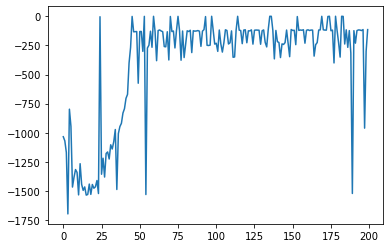

In [76]:
ddpg(lambda : gym.make("Pendulum-v0"), actor_critic=MLPActorCritic, seed=0, 
         steps_per_epoch=400, epochs=100, replay_size=int(10000), gamma=0.999, 
         rho=1e-3, pi_lr=1e-3, q_lr=1e-3, batch_size=1024, start_steps=2000, 
         update_after=1000, update_every=10, act_noise=0.3, num_test_episodes=10, 
         max_ep_len=200, activation = nn.Tanh, hidden_sizes=(32,32))